# Arctic regionional climatology for T and S
Notebook for the creation of a climatology using a backgroud field.     
Try to use Julia-1.3 or higher.

In [4]:
using DIVAnd
using PyPlot
using NCDatasets
using PhysOcean
using DataStructures
using PyPlot
using Dates
using Statistics
using Printf

## Files and directories
We assume that the data files are located in the `data` directory.     
You can either modify the variable `datadir` or copy the data files into `./data/`.      

In [5]:
datadir = "./data/"
figdir = "./figures"
datafile = joinpath(datadir, "data_from_SDN_2015-09_TS_ArcticOcean_QC_done_v2.nc")
varname = "salinity"
isfile(datafile)

true

If the files are large, it is wishable to read them and then convert them to a more suitable format using the function `saveos`, for example:
```julia
DIVAnd.saveobs(filename, varname, value, xy, ids,
               type_save = Float32,
               timeorigin = DateTime(1900,1,1,0,0,0),
               used = trues(size(ids)),
               )
```
Doing so, the reading of the data file(s) will be much faster, using:
```julia
obsvalue, obslon, obslat, obsdepth, obstime, obsid = loadobs(T, filename, varname)
```
Comment out the next cell if you have to change the format of the netCDF.

In [7]:
"""
@time obsval, obslon, obslat, obsdepth, obstime, obsid = NCODV.load(Float64, datafile, "Water body salinity");
datafile2 = joinpath(datadir, "data_from_SDN_2015-09_TS_ArcticOcean_QC_done_v2_obs.nc")

@time DIVAnd.saveobs(datafile2, varname, obsval, (obslon, obslat, obsdepth, obstime), obsid,
               type_save = Float64,
               timeorigin = DateTime(1900,1,1,0,0,0),
               used = trues(size(obsid)),
               );
"""

"@time obsval, obslon, obslat, obsdepth, obstime, obsid = NCODV.load(Float64, datafile, \"Water body salinity\");\ndatafile2 = joinpath(datadir, \"data_from_SDN_2015-09_TS_ArcticOcean_QC_done_v2_obs.nc\")\n\n@time DIVAnd.saveobs(datafile2, varname, obsval, (obslon, obslat, obsdepth, obstime), obsid,\n               type_save = Float64,\n               timeorigin = DateTime(1900,1,1,0,0,0),\n               used = trues(size(obsid)),\n               );\n"

## Inputs
### Grid and depth levels

In [54]:
Δx = 0.4
Δy = 0.1
lonr = 0.:Δx:80.
latr = 67.0:Δy:80.0
timerange = [Date(1890,1),Date(2020,12,31)];
"""
depthr = Float64.([0, 5, 10, 15, 20, 25, 30, 35, 40,
        45, 50, 55, 60, 65, 70, 75, 80, 85, 90,
        95, 100, 125, 150, 175, 200, 225, 250, 275, 300,
        325, 350, 375, 400, 425, 450, 475, 500]);
"""
depthr = Float64.([0, 10, 20, 30, 40, 50]);

### Data

In [10]:
@time obsval, obslon, obslat, obsdepth, obstime, obsid = loadobs(Float64, datafile2, varname);

 17.648382 seconds (81.22 M allocations: 10.052 GiB, 30.51% gc time)


Check the observation ranges:

In [11]:
checkobs((obslon, obslat, obsdepth, obstime), obsval, obsid)

┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/obsstat.jl:75


              minimum and maximum of obs. dimension 1: (0.0, 359.9998474121094)
              minimum and maximum of obs. dimension 2: (61.999000549316406, 82.94100189208984)
              minimum and maximum of obs. dimension 3: (-0.800000011920929, 5667.0)
              minimum and maximum of obs. dimension 4: (1931-07-06T00:00:00, 2015-02-26T13:36:00)
                          minimum and maximum of data: (0.0, 36.959999084472656)


The longitudes go from 0° to 360°E, but we want to have them between -180° to 180°     
(normaly than can be done with ODV during the export).

In [12]:
obslon[obslon .> 180.] = obslon[obslon .> 180.] .- 360.;

#### Quality check based on range
We see that the range for salinity is correct, so no need to check it further.     
Modify the values and uncomment the next cell if a range checking is needed.

In [13]:
"""
sel = (obsval .<= 40) .& (obsval .>= 0);
obsval = obsval[sel]
obslon = obslon[sel]
obslat = obslat[sel]
obsdepth = obsdepth[sel]
obstime = obstime[sel]
obsid = obsid[sel];
"""

"sel = (obsval .<= 40) .& (obsval .>= 0);\nobsval = obsval[sel]\nobslon = obslon[sel]\nobslat = obslat[sel]\nobsdepth = obsdepth[sel]\nobstime = obstime[sel]\nobsid = obsid[sel];\n"

In [46]:
~(isdir(figdir)) ? mkpath(figdir): @info "Creating directory $(figdir)"

LoadError: syntax: space required before colon in "?" expression

#### Plot unique observation locations

In [14]:
coords = [(x,y) for (x,y) in zip(obslon, obslat)];
coords_u = unique(coords);
@info "Total number of coordinates: $(length(coords))"
@info "Number of unique coordinates (profiles): $(length(coords_u))"
obslon_u = [x[1] for x in coords_u];
obslat_u = [x[2] for x in coords_u];

┌ Info: Total number of coordinates: 19059429
└ @ Main In[14]:3
┌ Info: Number of unique coordinates (profiles): 181064
└ @ Main In[14]:4


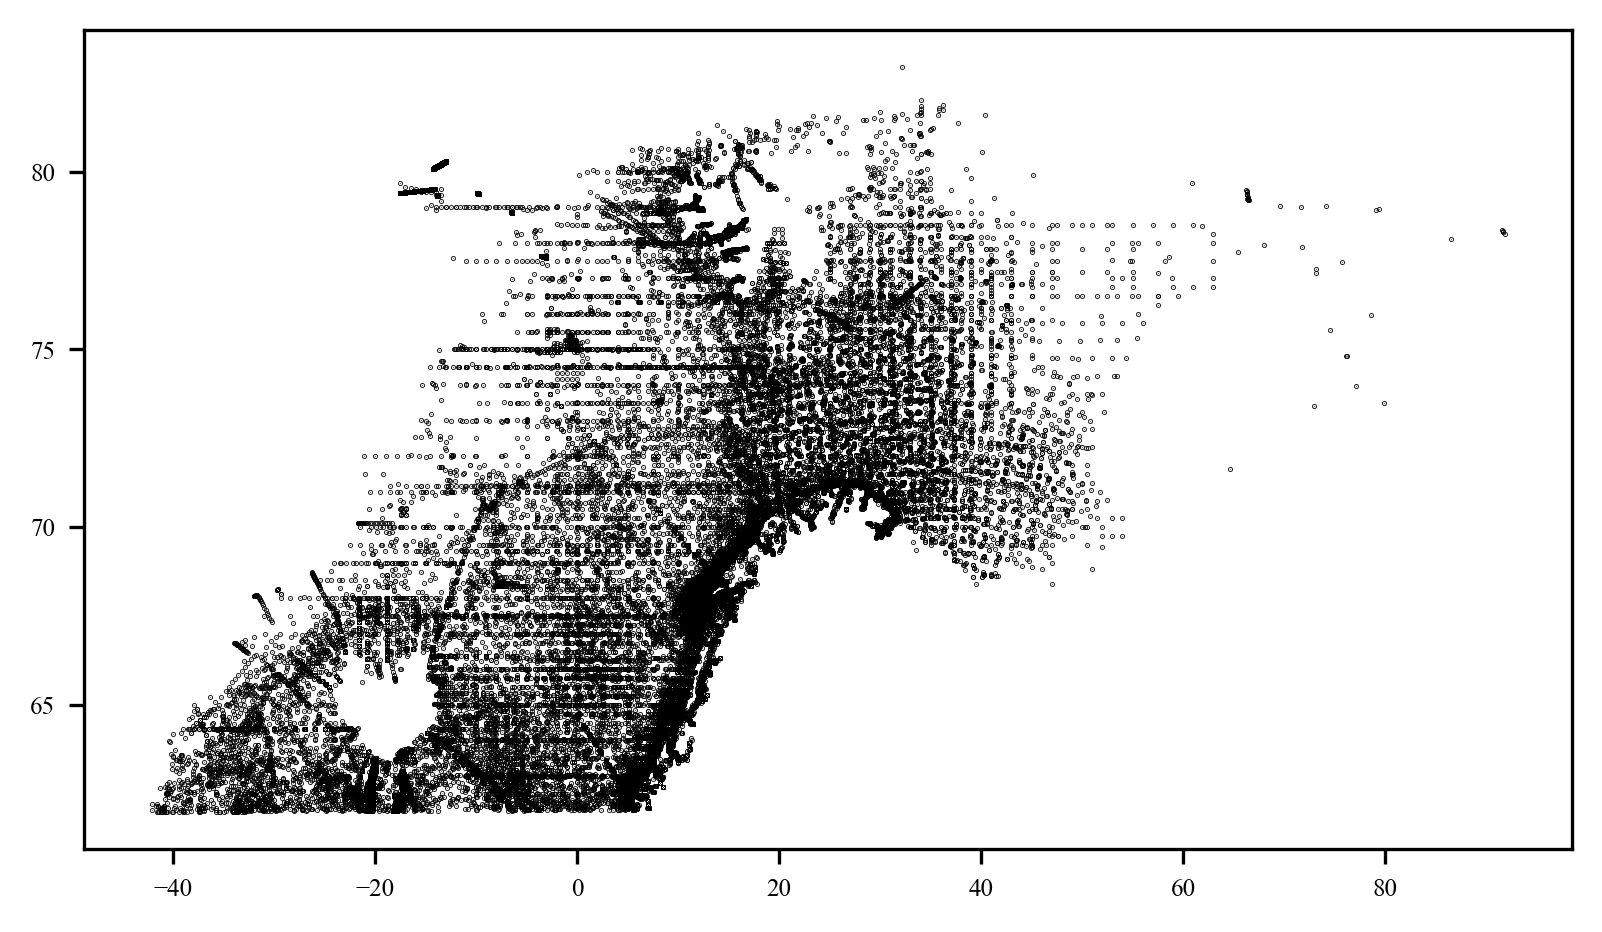

In [16]:
figure()
ax = subplot(1,1,1)
plot(obslon_u, obslat_u, "ko", markersize=.2)
aspect_ratio = 1/cos(mean(latr) * pi/180)
ax.tick_params("both",labelsize=6)
gca().set_aspect(aspect_ratio)
savefig(joinpath(figdir, "arctic_data_locations"))

### Bathymetry
We will work with a reduced resolution GEBCO bathymetry.

In [55]:
bathname = joinpath(datadir, "gebco_30sec_16.nc")
if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download", bathname)
else
    @info "Bathymetry file already downloaded"
end
@time bx, by, b = load_bath(bathname, true, lonr, latr);

  0.046014 seconds (420 allocations: 1.876 MiB)


┌ Info: Bathymetry file already downloaded
└ @ Main In[55]:5


#### Plotting

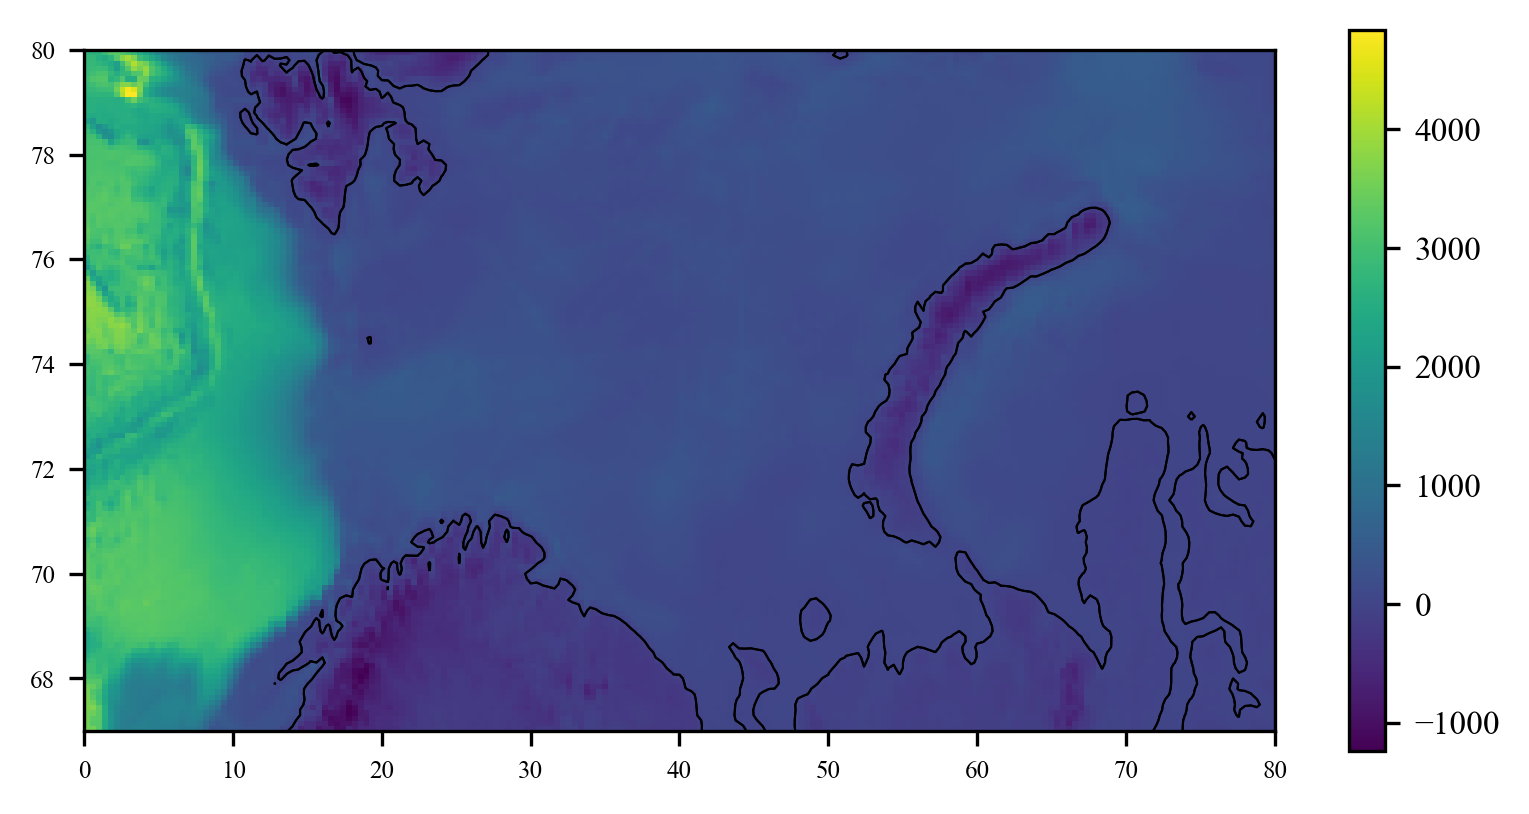

In [36]:
figure()
ax = subplot(1,1,1)
pcolor(bx,by,permutedims(b, [2,1]));
cb = colorbar(orientation="vertical", shrink=0.65)
cb.ax.tick_params(labelsize=8)
contour(bx,by,permutedims(b, [2,1]), [0, 0.1], colors="k", linewidths=.5)
gca().set_aspect(aspect_ratio)
ax.tick_params("both",labelsize=6)
savefig(joinpath(figdir, "arctic_bathymetry"))

#### Land-sea mask
We start with the surface mask to have a first idea of how the mask looks like.     

In [37]:
surfwater = b .>= depthr[1]
label = DIVAnd.floodfill(surfwater)
surfmask = label .== 1; # largest area has the label 1

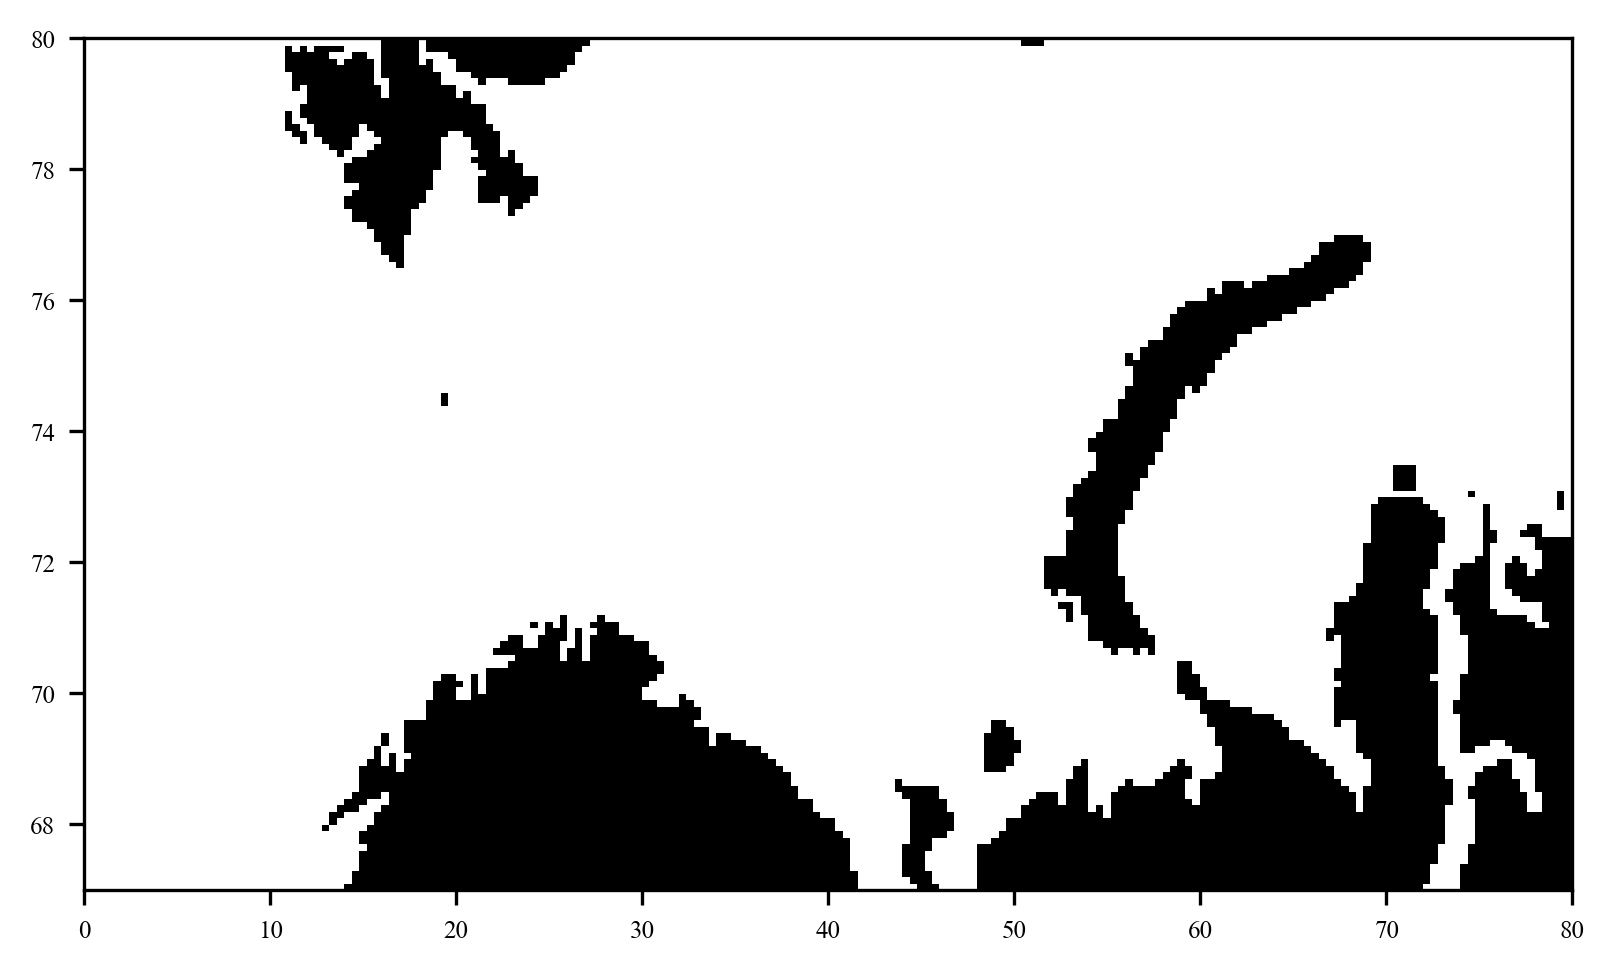

PyObject <matplotlib.collections.PolyCollection object at 0x7fd0ab875f50>

In [38]:
figure()
gca().set_aspect(aspect_ratio)
gca().tick_params("both", labelsize=6)
pcolor(bx, by ,surfmask', cmap=PyPlot.cm.binary_r)

3D mask

In [56]:
mask = falses(size(b,1),size(b,2),length(depthr))
for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = (b[i,j] >= depthr[k]) && surfmask[i,j]
        end
    end
end
@show size(mask)

size(mask) = (201, 131, 6)


(201, 131, 6)

## Analysis
### Background
The background field is a 10-year reference field prior to the analysis year    
For example for analysis year 2018, the period for the background is 2008-2017.     
The variable `yearlist` is then defined as a list of ranges (change the values in the [ ] to have the start and the end year).

In [57]:
yearlist = [y-10:y-1 for y = 2010:2018];
yearlist

9-element Array{UnitRange{Int64},1}:
 2000:2009
 2001:2010
 2002:2011
 2003:2012
 2004:2013
 2005:2014
 2006:2015
 2007:2016
 2008:2017

In [58]:
monthlist = [[2,3,4], [5,6,7], [8,9,10], [11,12,1]];  # Seasonal climatology
TSbackground = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist);

#### Analysis parameters

In [59]:
sz = (length(lonr), length(latr), length(depthr));
lenx = fill(200_000.,sz)   # 200 km
leny = fill(200_000.,sz)   # 200 km
lenz = [min(max(30.,depthr[k]/150),300.) for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]]
len = (lenx, leny, lenz);
epsilon2 = 0.1;

filenamebackground = "Water_body_$(replace(varname," "=>"_"))_Arctic_background.4Danl.nc"
filename = "Water_body_$(replace(varname," "=>"_"))_Arctic.4Danl.nc"

"Water_body_salinity_Arctic.4Danl.nc"

#### Metadata for the netCDF file

In [44]:
metadata = OrderedDict(
    # Name of the project (SeaDataCloud, SeaDataNet, EMODNET-chemistry, ...)
    "project" => "SeaDataCloud",

    # URN code for the institution EDMO registry,
    # e.g. SDN:EDMO::1579
    "institution_urn" => "SDN:EDMO::1579",

    # Production group
    #"production" => "Diva group",

    # Name and emails from authors
    "Author_e-mail" => ["Your Name1 <name1@example.com>", "Other Name <name2@example.com>"],

    # Source of the observation
    "source" => "observational data from SeaDataNet and World Ocean Atlas",

    # Additional comment
    "comment" => "Duplicate removal applied to the merged dataset",

    # SeaDataNet Vocabulary P35 URN
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p35
    # example: SDN:P35::WATERTEMP
    "parameter_keyword_urn" => "SDN:P35::EPC00001",

    # List of SeaDataNet Parameter Discovery Vocabulary P02 URNs
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p02
    # example: ["SDN:P02::TEMP"]
    "search_keywords_urn" => ["SDN:P02::PSAL"],

    # List of SeaDataNet Vocabulary C19 area URNs
    # SeaVoX salt and fresh water body gazetteer (C19)
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=C19
    # example: ["SDN:C19::3_1"]
    "area_keywords_urn" => ["SDN:C19::3_3"],

    "product_version" => "1.0",
    
    "product_code" => "something-to-decide",
    
    # bathymetry source acknowledgement
    # see, e.g.
    # * EMODnet Bathymetry Consortium (2016): EMODnet Digital Bathymetry (DTM).
    # https://doi.org/10.12770/c7b53704-999d-4721-b1a3-04ec60c87238
    # 
    # taken from
    # http://www.emodnet-bathymetry.eu/data-products/acknowledgement-in-publications
    #
    # * The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003
    #
    # taken from
    # https://www.bodc.ac.uk/projects/data_management/international/gebco/gebco_digital_atlas/copyright_and_attribution/
        
    "bathymetry_source" => "The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003",

    # NetCDF CF standard name
    # http://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
    # example "standard_name" = "sea_water_temperature",
    "netcdf_standard_name" => "sea_water_salinity",

    "netcdf_long_name" => "sea water salinity",

    "netcdf_units" => "1e-3",

    # Abstract for the product
    "abstract" => "...",

    # This option provides a place to acknowledge various types of support for the
    # project that produced the data
    "acknowledgement" => "...",

    "documentation" => "https://doi.org/doi_of_doc",

    # Digital Object Identifier of the data product
    "doi" => "...");

Check the metadata  before running the next cell.

In [ ]:
ncglobalattrib, ncvarattrib = SDNMetadata(metadata, filename, varname, lonr, latr)

Remove the background file if it already exists, and create the figure directory if needed.

In [60]:
if isfile(filenamebackground)
    rm(filenamebackground) # delete the previous analysis
    @info "Removing file $filenamebackground"
end

┌ Info: Removing file Water_body_salinity_Arctic_background.4Danl.nc
└ @ Main In[60]:3


Let's define a plotting function that well be applied at each time and depth level.

In [66]:
function plotres(timeindex, sel, fit, erri)
    tmp = copy(fit)
    nx,ny,nz = size(tmp)
    for i in 1:nz
        figure("Arctic analysis")
        ax = subplot(1,1,1)
        ax.tick_params("both",labelsize=6)
        ylim(minimum(latr) - Δy, maximum(latr) + Δy);
        xlim(minimum(lonr) - Δx, maximum(lonr) + Δx);
        title("Depth: $(depthr[i]) \n Time index: $(timeindex)", fontsize=6)
        pcolor(lonr.-Δx/2.,latr.-Δy/2, permutedims(tmp[:,:,i], [2,1]);
               vmin = 30., vmax = 38.)
        cb = colorbar(extend="max", orientation="vertical", shrink=0.8)
        cb.ax.tick_params(labelsize=8)

        contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0], colors = [[.5,.5,.5]])
        gca().set_aspect(aspect_ratio)

        figname = varname * @sprintf("_%02d",i) * @sprintf("_%03d_background.png",timeindex) 
        @info(figname)
        PyPlot.savefig(joinpath(figdir, figname), dpi=300, bbox_inches="tight");
        PyPlot.close_figs()
    end
end

plotres (generic function with 1 method)

#### Background analysis
We now have all the input to prepare the background field with `diva3d`.

In [67]:
dbinfo = @time diva3d((lonr,latr,depthr,TSbackground),
           (obslon,obslat,obsdepth,obstime), obsval,
           len, epsilon2,
           filenamebackground,varname,
           bathname=bathname,
           mask = mask,
           plotres=plotres,
           fitcorrlen = false,
           niter_e = 2,
           solver = :direct,
           MEMTOFIT = 120,
       );

┌ Info: Creating netCDF file
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/diva.jl:338
┌ Info: Time step 1 / 36
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/diva.jl:390
┌ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/diva.jl:575
┌ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/diva.jl:575
┌ Info: scaled correlation length (min,max) in dimension 3: (30.0, 30.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/diva.jl:575
┌ Info: number of windows: 1
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAndgo.jl:110
┌ Info: number of windows: 1
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAndgo.jl:110
┌ Info: salinity_01_001_background.png
└ @ Main In[66]:20
┌ Info: salinity_02_001_background.png
└ @ Main In[66]:20
┌ Info: salinity_03_001_backgrou

┌ Info: number of windows: 1
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAndgo.jl:110
┌ Info: salinity_01_008_background.png
└ @ Main In[66]:20
┌ Info: salinity_02_008_background.png
└ @ Main In[66]:20
┌ Info: salinity_03_008_background.png
└ @ Main In[66]:20
┌ Info: salinity_04_008_background.png
└ @ Main In[66]:20
┌ Info: salinity_05_008_background.png
└ @ Main In[66]:20
┌ Info: salinity_06_008_background.png
└ @ Main In[66]:20
┌ Info: Time step 9 / 36
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/diva.jl:390
┌ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/diva.jl:575
┌ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/diva.jl:575
┌ Info: scaled correlation length (min,max) in dimension 3: (30.0, 30.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/diva.jl:575
┌ In

┌ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/diva.jl:575
┌ Info: scaled correlation length (min,max) in dimension 3: (30.0, 30.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/diva.jl:575
┌ Info: number of windows: 1
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAndgo.jl:110
┌ Info: number of windows: 1
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAndgo.jl:110
┌ Info: salinity_01_016_background.png
└ @ Main In[66]:20
┌ Info: salinity_02_016_background.png
└ @ Main In[66]:20
┌ Info: salinity_03_016_background.png
└ @ Main In[66]:20
┌ Info: salinity_04_016_background.png
└ @ Main In[66]:20
┌ Info: salinity_05_016_background.png
└ @ Main In[66]:20
┌ Info: salinity_06_016_background.png
└ @ Main In[66]:20
┌ Info: Time step 17 / 36
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/diva.jl:390
┌ Info: scaled correlation length (min,max) in dime

┌ Info: salinity_01_023_background.png
└ @ Main In[66]:20
┌ Info: salinity_02_023_background.png
└ @ Main In[66]:20
┌ Info: salinity_03_023_background.png
└ @ Main In[66]:20
┌ Info: salinity_04_023_background.png
└ @ Main In[66]:20
┌ Info: salinity_05_023_background.png
└ @ Main In[66]:20
┌ Info: salinity_06_023_background.png
└ @ Main In[66]:20
┌ Info: Time step 24 / 36
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/diva.jl:390
┌ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/diva.jl:575
┌ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/diva.jl:575
┌ Info: scaled correlation length (min,max) in dimension 3: (30.0, 30.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/diva.jl:575
┌ Info: number of windows: 1
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAndgo.jl:110
┌ I

┌ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/diva.jl:575
┌ Info: scaled correlation length (min,max) in dimension 3: (30.0, 30.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/diva.jl:575
┌ Info: number of windows: 1
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAndgo.jl:110
┌ Info: number of windows: 1
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAndgo.jl:110
┌ Info: salinity_01_031_background.png
└ @ Main In[66]:20
┌ Info: salinity_02_031_background.png
└ @ Main In[66]:20
┌ Info: salinity_03_031_background.png
└ @ Main In[66]:20
┌ Info: salinity_04_031_background.png
└ @ Main In[66]:20
┌ Info: salinity_05_031_background.png
└ @ Main In[66]:20
┌ Info: salinity_06_031_background.png
└ @ Main In[66]:20
┌ Info: Time step 32 / 36
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/diva.jl:390
┌ Info: scaled correlation length (min,max) in dime

1344.360792 seconds (5.80 M allocations: 555.348 GiB, 35.74% gc time)


### Final analysis
#### Parameters
We define the periods of interest for the final climatology.

In [69]:
yearlist = [[2010:2018]];
monthlist = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]];  # Seasonal climatology
TS = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist);

We remove the final netCDF file if it exists.

In [26]:
if isfile(filename)
    rm(filename) # delete the previous analysis
    @info "Removing file $filename"
end

Now we can perform the analysis using background field, defined through the option      
`background = DIVAnd.backgroundfile(filenamebackground,varname,TSbackground)`:      
* `filenamebackground` is the name of the netCDF that you have created with the background
* `varname` is the name of the variable as written in the background netCDF and
* `TSbackground` is the *TimeSelector` object used to compute the background.

With these options set, the new analysis will select the correct background according to the considered period.     
We now have 16 time steps: 4 seasons times 4 year periods.

In [28]:
dbinfo = @time diva3d((lonr,latr,depthr,TS),
    (obslon,obslat,obsdepth,obstime), obsval,
    len, epsilon2,
    filename,varname,
    bathname=bathname,
    plotres = plotres,
    mask = mask,
    fitcorrlen = false,
    niter_e = 2,
    background = DIVAnd.backgroundfile(filenamebackground,varname,TSbackground),
    solver = solver,
    MEMTOFIT = 120,
);

@show length(obslat);

┌ Info: Creating netCDF file
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/diva.jl:330
┌ Info: Time step 1 / 16
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/diva.jl:382
┌ Info: analysis time index 1 uses the backgrond time index 1
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/utils.jl:736
┌ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/diva.jl:567
┌ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/diva.jl:567
┌ Info: scaled correlation length (min,max) in dimension 3: (30.0, 30.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/diva.jl:567
┌ Info: number of windows: 1
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/DIVAndgo.jl:111
┌ Info: number of windows: 1
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/DIVAndgo.jl:111
┌ Info: Time s

┌ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/diva.jl:567
┌ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/diva.jl:567
┌ Info: scaled correlation length (min,max) in dimension 3: (30.0, 30.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/diva.jl:567
┌ Info: number of windows: 1
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/DIVAndgo.jl:111
┌ Info: number of windows: 1
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/DIVAndgo.jl:111
┌ Info: Time step 11 / 16
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/diva.jl:382
┌ Info: analysis time index 11 uses the backgrond time index 7
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/utils.jl:736
┌ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
└ @ DIVAnd /home/ctroupin/.juli

150.182604 seconds (57.10 M allocations: 39.276 GiB, 0.31% gc time)
length(obslat) = 11180368


In [23]:
filename

"Water_body_salinity_Baltic.4Danl.nc"